### project 과정
뉴스 요약하기
- 정규화만 사용하고, 불용어를 처리하지 않은 경우
- 정규화와 불용어를 모두 처리한 경우

조건
- 동일한 하이퍼 파라미터, 동일한 모델로 구성

문제점
과대적합이 발생하는 문제를 확인하고 다양하게 실험해봄
- adamW: lr: 1e-3, 조기종료 5로 설정했을 때  train_loss는 감소하고, val_loss가 감소하다 상승하는 것을 확인함(과대 적합)
- adamW: lr: 5e-4, 조기종료 15로 변경했을 때, 이전보다 나이지긴 했으나 val_loss가 감소하다 상승하는 것을 확인함(과대 적합)
- batch_size: 256 > 128로 변경: 가중치 업데이트를 더 자주 하도록 변경
- adamW: lr: 1e-3, 조기종료 15로 변경했을 때 weight_decay: 1e-4로 약한 규제 설정 이전보다 더 나아지긴 했으나 과대적합이 발생
- adamW: lr: 1e-3, 조기종료 15로 변경했을 때 weight_decay: 1e-3로 규제를 좀 더 높여서 실험했으나 과대적합이 발생함

원인 분석
- stopwords기반 토크나이저이가 때문에 OOV(UNK)가 발생함 따라서 모델 학습에 방해를 줌
- Seq2Seq + Attention 구조이기 때문에 문장 길이를 60으로 설정했을 때 가중치가 제대로 업데이트가 안 되었을 수도 있음
- 하이퍼파라미터의 최적화 오류
    - vocab 크기가 작음 > 빈도수 기반이기 때문에 불용어를 제외하고도 불필요한 단어가 vocab에 포함되어 있을 수 있음
    - 모델의 하이퍼 파라미터 오류 > 데이터에 적절하지 않은 값을 설정
- 모델의 구조 설계 오류 > 깊은 레이어, 문장이 길어졌을 때, drop out을 설정해서 과대 적합을 개선할 수 있음

### 회고
text 데이터를 다를 때는 불용어 처리가 반드시 필요하다고 생각했으나 오히려 문맥을 훼손시킬 수 있다는 것을 알게 되었다.(모델의 성능 저하)
그 외에도 띄어쓰기 기반 토크나이저를 사용하면 안 되는 이유를 다시금 알게 되었다.


In [1]:
import nltk
import numpy as np
import pandas as pd
import summa
import os
import re
import requests
from importlib.metadata import version
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from summa.summarizer import summarize
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

import urllib.request
import warnings

# NLTK 리소스 다운로드 (필요 시 주석 해제)
# nltk.download('stopwords')
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [2]:
print(nltk.__version__)
print(pd.__version__)
print(version('summa'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

3.9.2
2.3.3
1.2.0
Using device: cuda


In [3]:
# os.makedirs('./data', exist_ok=True)

In [4]:
# import urllib.request
# urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_headlines/master/news_headlines_more.csv", filename="news_headlines_more.csv")
# data = pd.read_csv('news_headlines_more.csv', encoding='iso-8859-1')

In [5]:
# !pip install nltk
# !pip install beautifulsoup4
# !pip install lxml
# !pip install summa

### config

In [3]:
text_max_len = 60           # text 최대 길이
headlines_max_len = 10      # headlines 최대 길이 
src_vocab_size = 8000       
tar_vocab_size = 2000

# Hyperparameters
batch_size = 128
embedding_dim = 128
hidden_size = 256

epochs = 50
learning_rate = 1e-3
patience = 15

# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시

In [4]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [5]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [6]:
class NewsDataProcessor:
    def __init__(self, file_path):
        """
        클래스 초기화 메서드
        :param file_path: 데이터 파일 경로
        """
        self.file_path = file_path
        self.data = None

    def load_data(self):
        """
        데이터를 불러오고 기본적인 정보를 출력하는 메서드
        """
        # encoding은 원본 코드 유지
        self.data = pd.read_csv(self.file_path, encoding='iso-8859-1')
        print('전체 샘플수 :', (len(self.data)))

        print(self.data.head())

        # 필요한 컬럼만 선택
        self.data = self.data[['headlines', 'text']]

        # 랜덤한 15개 샘플 출력
        print(self.data.sample(15))
        
        # 체이닝이나 외부 변수 할당을 위해 self.data 반환
        return self.data

    def data_preprocess(self, is_text, is_headlines=False):
        """
        데이터 전처리 메서드 (중복 제거, 결측치 제거, 불용어 처리 등)
        """
        if self.data is None:
            print("데이터가 로드되지 않았습니다. load_data()를 먼저 실행해주세요.")
            return

        print('text 열에서 중복을 배제한 유일한 샘플의 수 :', self.data['text'].nunique())
        print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', self.data['headlines'].nunique())

        # inplace=True 를 설정하면 내부 데이터를 직접 변경
        self.data.drop_duplicates(subset=['text'], inplace=True)
        print('전체 샘플수 :', (len(self.data)))

        print(self.data.isnull().sum())

        self.data.dropna(axis=0, inplace=True)
        print('전체 샘플수 :', (len(self.data)))

        # NLTK stopwords 확인
        try:
            print('불용어 개수 :', len(stopwords.words('english')))
            print(stopwords.words('english'))
        except LookupError:
            print("NLTK stopwords가 다운로드되지 않았습니다. nltk.download('stopwords')가 필요할 수 있습니다.")

        # 전체 text 데이터에 대한 전처리
        print("text 전처리를 시작합니다...")
        clean_text = []
        for sentence in self.data['text']:
            # 외부 함수 preprocess_sentence 호출 (기존 코드 유지)
            clean_text.append(preprocess_sentence(sentence, is_text))

        print("text 전처리 후 결과: ", clean_text[:5])

        # 전체 headlines 데이터에 대한 전처리
        print("headlines 전처리를 시작합니다...")
        clean_headlines = []
        for sentence in self.data['headlines']:
            # 외부 함수 preprocess_sentence 호출 (기존 코드 유지)
            clean_headlines.append(preprocess_sentence(sentence, remove_stopwords=is_headlines))

        print("headlines 전처리 후 결과: ", clean_headlines[:5])

        # 전처리된 데이터 업데이트
        self.data['text'] = clean_text
        self.data['headlines'] = clean_headlines

        # 빈 값을 Null 값으로 변환
        self.data.replace('', np.nan, inplace=True)

        print(self.data.isnull().sum())

        self.data.dropna(axis=0, inplace=True)
        print('전체 샘플수 (최종) :', (len(self.data)))
        
        return self.data

In [7]:
#훈련데이터와 테스트데이터 나누기
def im_show(text_len, headlines_len):
    print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
    print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
    print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
    print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
    print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
    print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

    plt.subplot(1,2,1)
    plt.boxplot(text_len)
    plt.title('text')
    plt.subplot(1,2,2)
    plt.boxplot(headlines_len)
    plt.title('headlines')
    plt.tight_layout()
    plt.show()

    plt.title('text')
    plt.hist(text_len, bins = 40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

    plt.title('headlines')
    plt.hist(headlines_len, bins = 40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

In [8]:
#데이터 분포 확인
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [9]:
def create_train_test_sets(data, text_max_len, headlines_max_len):
    text_len = [len(s.split()) for s in data['text']]
    headlines_len = [len(s.split()) for s in data['headlines']]
    im_show(text_len, headlines_len)

    below_threshold_len(text_max_len, data['text'])
    below_threshold_len(headlines_max_len, data['headlines'])

    data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
    data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

    print('전체 샘플수 :', (len(data)))

    # 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
    data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
    data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
    data.head()

    encoder_input = np.array(data['text']) # 인코더의 입력
    decoder_input = np.array(data['decoder_input']) # 디코더의 입력
    decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

    indices = np.arange(encoder_input.shape[0])
    np.random.shuffle(indices)
    print(indices)

    encoder_input = encoder_input[indices]
    decoder_input = decoder_input[indices]
    decoder_target = decoder_target[indices]

    n_of_val = int(len(encoder_input)*0.2)
    print('테스트 데이터의 수 :', n_of_val)

    encoder_input_train = encoder_input[:-n_of_val]
    decoder_input_train = decoder_input[:-n_of_val]
    decoder_target_train = decoder_target[:-n_of_val]

    encoder_input_test = encoder_input[-n_of_val:]
    decoder_input_test = decoder_input[-n_of_val:]
    decoder_target_test = decoder_target[-n_of_val:]

    print('훈련 데이터의 개수 :', len(encoder_input_train))
    print('훈련 레이블의 개수 :', len(decoder_input_train))
    print('테스트 데이터의 개수 :', len(encoder_input_test))
    print('테스트 레이블의 개수 :', len(decoder_input_test))
  
    return encoder_input_train, decoder_input_train, decoder_target_train, \
               encoder_input_test, decoder_input_test, decoder_target_test

In [10]:
# 정수 인코딩
def src_tokenizer(text): # 토크나이저 정의
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

def build_vocab(texts):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 단어 집합 생성 (빈도가 높은 순서대로)
    for word, _ in word_counter.most_common():
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

def tar_tokenizer(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

# 텐서 변환 함수 (리스트 → PyTorch 텐서)
def convert_to_tensor(sequences):
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수 (PyTorch `pad_sequence()` 활용)
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    sequences = convert_to_tensor(sequences)  # 리스트를 텐서로 변환
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=padding_value)  # 패딩 적용
    return padded_seqs[:, :maxlen]  # maxlen 길이로 자르기 (최대 길이 초과 방지)


In [11]:
# 인코더 디코더 모델 정의

# 인코더
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x): # 인코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)  # LSTM 실행
        return output, hidden, cell

# 디코더 
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout=0.4, num_layers=3):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout,
            batch_first=True
        )

    def forward(self, x, hidden, cell): # 디코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # 초기 상태를 인코더에서 전달받음
        return output, hidden, cell


In [12]:
# Seq2Seq 모델 정의
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, vocab_size):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.softmax_layer = nn.Linear(hidden_size, vocab_size)  # 출력층 정의

    def forward(self, encoder_input, decoder_input):
        # 인코더 실행
        encoder_output, hidden, cell = self.encoder(encoder_input)

        # 디코더 실행
        decoder_output, _, _ = self.decoder(decoder_input, hidden, cell)

        # 출력층 적용 (Softmax는 Loss 내부에서 적용되므로 생략 가능)
        output = self.softmax_layer(decoder_output)
        return output


In [13]:
# Seq2Seq + Attention 모델 정의
class Attention_dot(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_dot, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)  # 어텐션 가중치
        self.v = nn.Linear(hidden_size, 1, bias=False)  # 어텐션 가중치 벡터

    def forward(self, decoder_output, encoder_outputs):
        attn_weights = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_weights, dim=-1)  # 어텐션 가중치 정규화
        attn_out = torch.bmm(attn_weights, encoder_outputs)

        return attn_out

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = Attention_dot(hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층

    def forward(self, encoder_input, decoder_input):
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, encoder_outputs)

        # 어텐션 결과와 디코더 출력 연결
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)

        # 어텐션 결합 후 최종 출력
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))
        output = self.output_layer(decoder_concat_output)

        return output


In [14]:
# 학습 함수
def train_model(model, train_loader, test_loader, criterion, epochs, patience):
    train_losses = []
    val_losses = []

    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3) 

    best_val_loss = float('inf')
    early_stop_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for encoder_input, decoder_input, target in train_loader:
            optimizer.zero_grad()

            # 정수형 변환
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            # 모델 실행
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation loss 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()

                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)

                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            model.load_state_dict(best_model_wts)
            break

    return train_losses, val_losses

In [15]:
# 인퍼런스 모델

# 인코더 설계
def encode_input(encoder, input_seq):
    encoder_outputs, hidden, cell = encoder(input_seq)
    return encoder_outputs, hidden, cell

#Decoder + Attention
class DecoderWithAttention(nn.Module):
    def __init__(self, decoder, attention, hidden_size, vocab_size):
        super(DecoderWithAttention, self).__init__()
        self.decoder = decoder  # 기존 디코더
        self.attention = attention  # 어텐션 레이어
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합 레이어
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층
        self.softmax = nn.Softmax(dim=-1)  # 소프트맥스

    def forward(self, decoder_inputs, decoder_hidden_state, decoder_state_h, decoder_state_c):
        # 디코더 실행
        decoder_outputs, state_h, state_c = self.decoder(decoder_inputs, decoder_state_h, decoder_state_c)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, decoder_hidden_state)

        # 어텐션과 디코더 출력 결합
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))

        # 최종 출력층 적용
        decoder_outputs2 = self.softmax(self.output_layer(decoder_concat_output))

        return decoder_outputs2, state_h, state_c

def decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, headlines_max_len, device):
    # 입력을 PyTorch Tensor로 변환
    input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)

    # 인코더 실행하여 초기 상태(hidden, cell) 얻기
    with torch.no_grad():
        e_out, e_h, e_c = encoder(input_seq)

    e_out = e_out.repeat(1, text_max_len, 1)  # 차원 조정 (np.tile 대신 repeat 사용)

    # <SOS>에 해당하는 토큰 생성
    target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 디코더 실행
        with torch.no_grad():
            output_tokens, h, c = decoder(target_seq, e_h, e_c)

        # 가장 높은 확률을 가진 단어 선택
        sampled_token_index = torch.argmax(output_tokens[0, -1, :]).item()
        sampled_token = tar_index_to_word[sampled_token_index]

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # 종료 조건: <eos>에 도달하거나 최대 길이를 초과하면 중단
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len - 1):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence

In [16]:
# 모델 테스트하기

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq, src_index_to_word):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0:  # 패딩(0) 제외
            temp = temp + src_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq, tar_word_to_index, tar_index_to_word):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0 and key != tar_word_to_index['sostoken'] and key != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()  # 양쪽 공백 제거

In [ ]:
# 추출적 요약
def Extractive(text):
    print(text[:1500])
    url = "https://raw.githubusercontent.com/modulabs/Aiffel_Resources/main/matrix_synopsis.txt"
    text = requests.get(url, timeout=10).text

    print('headlines:')
    print(summarize(text, ratio=0.01))

    print('headlines:')
    print(summarize(text, ratio=0.01, split=True))

    print('headlines:')
    print(summarize(text, words=50))

---
### Text 불용어 제거 X

### 데이터 처리

In [21]:
processor = NewsDataProcessor('./data/news_summary_more.csv')

In [22]:
processor.load_data()

전체 샘플수 : 98401
                                           headlines  \
0  upGrad learner switches to career in ML & Al w...   
1  Delhi techie wins free food from Swiggy for on...   
2  New Zealand end Rohit Sharma-led India's 12-ma...   
3  Aegon life iTerm insurance plan helps customer...   
4  Have known Hirani for yrs, what if MeToo claim...   

                                                text  
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1  Kunal Shah's credit card bill payment platform...  
2  New Zealand defeated India by 8 wickets in the...  
3  With Aegon Life iTerm Insurance plan, customer...  
4  Speaking about the sexual harassment allegatio...  
                                               headlines  \
64037  Railway Minister orders field work for 125 top...   
83594  I fear for my life: RJD man who failed to defe...   
44946  ICC suspends Pune pitch curator caught in stin...   
85357  IAF pilot gets jail for stealing remotes, refu...   
65667  Venezuela r

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [23]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text, False))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought was great infact ordered twice and the third ordered wasfor my mother and father
headlines: great way to start the day


In [24]:
processor.data_preprocess(is_text=False, is_headlines=False)

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
전체 샘플수 : 98360
headlines    0
text         0
dtype: int64
전체 샘플수 : 98360
불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor',

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant an alumnus of upgrad and iiit pg p...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india by wickets in the f...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...
...,...,...
98396,crpf jawan axed to death by maoists in chhatti...,crpf jawan was on tuesday axed to death with s...
98397,first song from sonakshi sinha noor titled uff...,uff yeh the first song from the sonakshi sinha...
98398,the matrix film to get reboot reports,according to reports new version of the scienc...
98399,snoop dogg aims gun at clown dressed as trump ...,new music video shows rapper snoop dogg aiming...


---
### 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 56.180195201301345
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


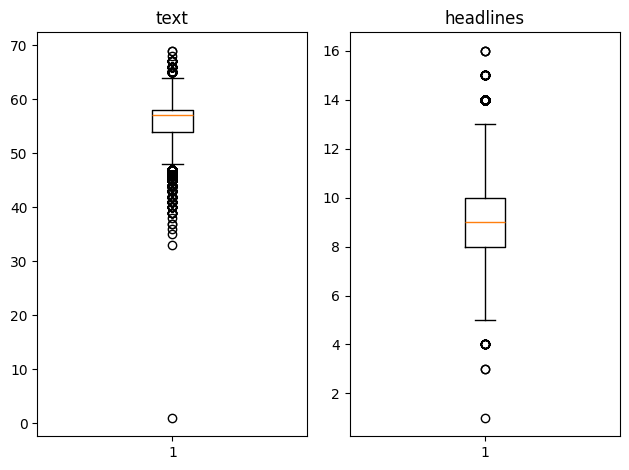

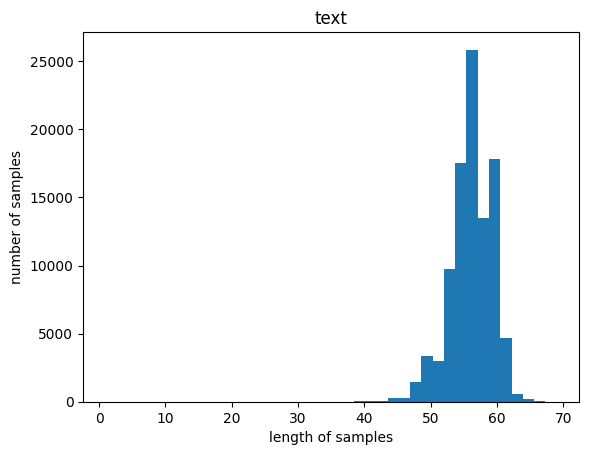

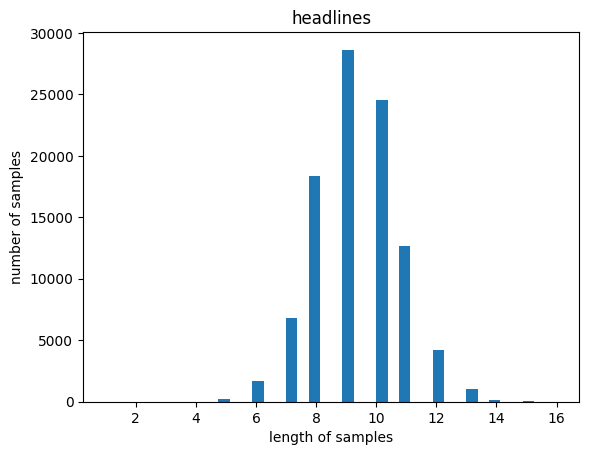

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.9443777958519723
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687
전체 샘플수 : 76449
[59949 19273 33973 ... 32679 61521 50772]
테스트 데이터의 수 : 15289
훈련 데이터의 개수 : 61160
훈련 레이블의 개수 : 61160
테스트 데이터의 개수 : 15289
테스트 레이블의 개수 : 15289


In [25]:
(encoder_input_train, decoder_input_train, decoder_target_train,
               encoder_input_test, decoder_input_test, decoder_target_test) = create_train_test_sets(processor.data, text_max_len, headlines_max_len)

---
### 정수 인코딩

In [26]:
src_vocab = build_vocab(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [27]:
threshold = 7

# 전처리된 데이터 사용
text_data = processor.data['text'].tolist()
headlines_data = processor.data['headlines'].tolist()
# 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 76476
등장 빈도가 6번 이하인 희귀 단어의 수: 51782
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24694
단어 집합에서 희귀 단어의 비율: 67.71013128301689
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8957871717900703


In [28]:
src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)

In [29]:
# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_test_seq[:3])

[[324, 371, 26, 147, 22, 216, 678, 1947, 29, 605, 2, 1, 3294, 11, 926, 57, 2899, 2096, 1056, 3, 25, 60, 5, 2, 61, 182, 1, 1371, 3294, 1, 7336, 1, 3, 546, 49, 3, 5040, 1, 1231, 2, 1947, 62, 1777, 57, 14, 6756, 590, 1, 6, 831, 927, 3, 105, 3022, 200, 2, 3294], [2, 970, 128, 5, 1791, 1416, 6, 3184, 245, 578, 166, 2318, 1, 8, 31, 226, 2, 477, 3059, 14, 3023, 1, 8, 31, 4703, 9, 2, 254, 5143, 2419, 56, 1, 2, 56, 1283, 14, 6392, 5693, 23, 424, 1844, 32, 1844, 7829, 1, 1, 1, 1, 6, 1, 1, 4, 624, 2052], [690, 562, 2632, 30, 27, 2, 1, 912, 1, 815, 3673, 9, 1648, 1432, 1207, 772, 177, 11, 20, 3538, 13, 6, 16, 13, 992, 3, 264, 15, 211, 3673, 3631, 20, 255, 442, 900, 1959, 1207, 772, 551, 1, 1387, 4, 513, 1, 513, 4573, 16, 38, 111, 4444, 473, 26, 3538, 1598]]
[[2, 213, 5, 990, 63, 913, 173, 4, 374, 378, 1, 1, 4, 764, 8, 3683, 17, 3, 2383, 137, 26, 10, 1, 41, 679, 523, 505, 1352, 40, 2197, 82, 3628, 6367, 168, 14, 1320, 913, 39, 12, 2, 50, 84, 2, 92, 4847, 7864, 1, 2823, 466, 5, 71, 3746, 12, 168, 4,

In [30]:
tar_vocab = build_vocab(decoder_input_train)

In [31]:
threshold = 6

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27865
등장 빈도가 5번 이하인 희귀 단어의 수: 18671
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9194
단어 집합에서 희귀 단어의 비율: 67.00520366050601
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.934438897012047


In [32]:
tar_vocab = build_limited_vocab(decoder_input_train + decoder_target_train, tar_vocab_size)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train_seq[:5])
print('target')
print('decoder ',decoder_target_train_seq[:5])

input
input  [[2, 105, 6, 1, 7, 24, 249, 1, 1], [2, 1037, 1676, 1, 255, 1, 1, 6, 1], [2, 283, 1, 352, 8, 389, 9, 1, 1], [2, 1284, 1, 1543, 114, 98, 14, 8, 539], [2, 1, 1, 106, 32, 1, 6, 1, 1719]]
target
decoder  [[105, 6, 1, 7, 24, 249, 1, 1, 3], [1037, 1676, 1, 255, 1, 1, 6, 1, 3], [283, 1, 352, 8, 389, 9, 1, 1, 3], [1284, 1, 1543, 114, 98, 14, 8, 539, 3], [1, 1, 106, 32, 1, 6, 1, 1719, 3]]


In [33]:
drop_train = [index for index, (seq_enc, seq_dec) in enumerate(zip(encoder_input_train, decoder_input_train))
              if len(seq_enc) == 0 or len(seq_dec) == 1]

drop_test = [index for index, (seq_enc, seq_dec) in enumerate(zip(encoder_input_test, decoder_input_test))
             if len(seq_enc) == 0 or len(seq_dec) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 61160
훈련 레이블의 개수 : 61160
테스트 데이터의 개수 : 15289
테스트 레이블의 개수 : 15289


In [34]:
# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=headlines_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=headlines_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=headlines_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=headlines_max_len)

---
### 모델 정의

In [35]:
# 인코더 모델 생성
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [36]:
# 디코더 모델 생성
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [37]:
# 모델 정의
Seq_model = Seq2Seq(encoder, decoder, tar_vocab_size)
print(Seq_model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(2000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (softmax_layer): Linear(in_features=256, out_features=2000, bias=True)
)


In [38]:
# 모델 생성
SeqA_model = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, hidden_size)
print(SeqA_model)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(8000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(2000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (attention): Attention_dot(
    (attn): Linear(in_features=256, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (concat): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=2000, bias=True)
)


---
### 모델 훈련하기

In [39]:
# PyTorch DataLoader 설정
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
%%time
# 30분 이상 시간이 걸릴 수 있습니다. GPU 환경에서 학습하는 것을 권장합니다.
# 학습 실행
train_losses, val_losses = train_model(SeqA_model, train_loader, test_loader, criterion, epochs=epochs, patience=patience)

Epoch 1/50 | Train Loss: 5.0373 | Val Loss: 4.8055
Epoch 2/50 | Train Loss: 4.6311 | Val Loss: 4.3720
Epoch 3/50 | Train Loss: 4.2179 | Val Loss: 4.0336
Epoch 4/50 | Train Loss: 3.8761 | Val Loss: 3.7373
Epoch 5/50 | Train Loss: 3.5822 | Val Loss: 3.5140
Epoch 6/50 | Train Loss: 3.3512 | Val Loss: 3.3542
Epoch 7/50 | Train Loss: 3.1614 | Val Loss: 3.2297
Epoch 8/50 | Train Loss: 3.0015 | Val Loss: 3.1442
Epoch 9/50 | Train Loss: 2.8604 | Val Loss: 3.0758
Epoch 10/50 | Train Loss: 2.7395 | Val Loss: 3.0287
Epoch 11/50 | Train Loss: 2.6314 | Val Loss: 2.9952
Epoch 12/50 | Train Loss: 2.5338 | Val Loss: 2.9736
Epoch 13/50 | Train Loss: 2.4479 | Val Loss: 2.9558
Epoch 14/50 | Train Loss: 2.3663 | Val Loss: 2.9530
Epoch 15/50 | Train Loss: 2.2958 | Val Loss: 2.9392
Epoch 16/50 | Train Loss: 2.2278 | Val Loss: 2.9582
Epoch 17/50 | Train Loss: 2.1670 | Val Loss: 2.9562
Epoch 18/50 | Train Loss: 2.1097 | Val Loss: 2.9676
Epoch 19/50 | Train Loss: 2.0521 | Val Loss: 2.9884
Epoch 20/50 | Train L

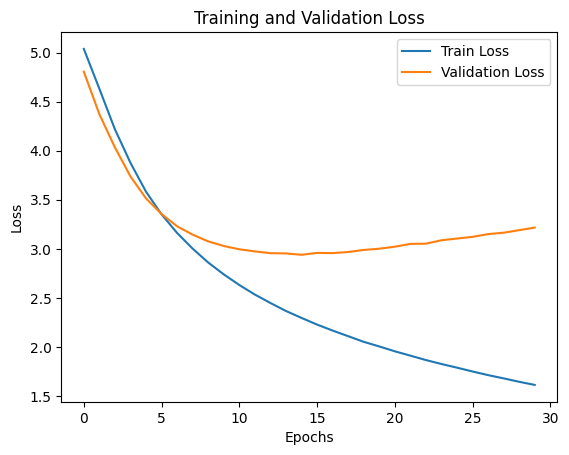

In [41]:
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

---
### 인퍼런스 모델 구현하기

In [42]:
src_index_to_word = {idx: word for word, idx in src_vocab.items()} # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_vocab # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()} # 요약 단어 집합에서 정수 -> 단어를 얻음

In [43]:
decoder.to(device)

# 이전 시점의 상태들을 저장하는 텐서
num_layers = 3  # 디코더 LSTM 레이어 개수 (설정에 맞춰 조정)
batch_size = 1

decoder_state_input_h = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_state_input_c = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_input = torch.zeros((batch_size, 1), dtype=torch.long, device=device)

dec_emb2 = decoder.embedding(decoder_input)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder(decoder_input, decoder_state_input_h, decoder_state_input_c)


In [44]:
# 기존 Attention 클래스 사용
attention_layer = Attention_dot(hidden_size)

# 디코더 모델 생성
decoder_model = DecoderWithAttention(decoder, attention_layer, hidden_size, tar_vocab_size)

---
### 모델 테스트하기

In [45]:
%%time
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i], src_index_to_word))
    print("실제 요약 :", seq2headlines(decoder_input_test[i], tar_word_to_index, tar_index_to_word))
    input_seq = torch.tensor(encoder_input_test[i], dtype=torch.long, device=device).unsqueeze(0)
    print("예측 요약 :", decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, headlines_max_len, device))
    print("\n")

원문 : nasa has developed deep space atomic clock to provide astronauts with their position and <UNK> during space exploration missions most spacecraft are tracked using two way methods by measuring the time taken by ground based <UNK> to return however atomic <UNK> enable one way tracking removing the need to send signal back to earth thus providing autonomous real time navigation
실제 요약 : nasa develops <UNK> <UNK> for <UNK> space travel
예측 요약 :  high case seeks high high gold gold kerala film


원문 : the mahindra group and the piramal group have expressed interest in buying sahara group <UNK> valley resort town according to the official <UNK> the supreme court on wednesday allowed the sale of the property in <UNK> after lawyers said selling the property as whole was difficult this comes after sahara failed to deposit dues to refund its investors
실제 요약 : mahindra <UNK> <UNK> in <UNK> <UNK> <UNK> <UNK>
예측 요약 :  denies denies data women last starrer by by salman


원문 : reddit user has share

<timed exec>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_358210/3537739887.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)


예측 요약 :  world play by to gets top to gets top


원문 : the uidai on saturday denied media reports which claimed that anyone can access personal details of all aadhaar holders due to an <UNK> interface operated by state owned <UNK> company for <UNK> customers identities there is no truth in this story as there has been absolutely no breach of uidai aadhaar database the uidai said
실제 요약 : <UNK> denies reports on aadhaar leak via govt <UNK>
예측 요약 :  denies denies data starrer cr starrer daughter salman during


원문 : priyanka chopra fianc and singer nick jonas on saturday said years ago today was diagnosed with type <UNK> sharing picture of himself from years ago jonas revealed his weight was <UNK> <UNK> after losing weight due to high blood sugar he added he <UNK> his physical health started working out and eating healthy
실제 요약 : years ago today was <UNK> with <UNK> nick <UNK>
예측 요약 :  gets denies at at at at at at at


원문 : dalit christian from kerala was found dead two days after he marr

---
### 추출적 요약 해보기

In [46]:
Extractive(text)

sostoken delhi airport to get additional counters by january
headlines:
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.
headlines:
['Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.']
headlines:
Morpheus and Neo are walking down a standard city street in what appears to be the Matrix.
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.


In [47]:
# 1. 모델 객체 삭제 (파이썬 레벨)
del SeqA_model
del encoder
del decoder

# 2. 가비지 컬렉터 실행 (찌꺼기 청소)
import gc
gc.collect()

# 3. GPU 메모리 캐시 비우기 (PyTorch 레벨)
torch.cuda.empty_cache()

---
### 불용어 제거

### 데이터 처리

In [18]:
processor_re = NewsDataProcessor('./data/news_summary_more.csv')

In [19]:
processor_re.load_data()

전체 샘플수 : 98401
                                           headlines  \
0  upGrad learner switches to career in ML & Al w...   
1  Delhi techie wins free food from Swiggy for on...   
2  New Zealand end Rohit Sharma-led India's 12-ma...   
3  Aegon life iTerm insurance plan helps customer...   
4  Have known Hirani for yrs, what if MeToo claim...   

                                                text  
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1  Kunal Shah's credit card bill payment platform...  
2  New Zealand defeated India by 8 wickets in the...  
3  With Aegon Life iTerm Insurance plan, customer...  
4  Speaking about the sexual harassment allegatio...  
                                               headlines  \
3207   Nitin Gadkari waiting for hung Lok Sabha: Shiv...   
51825  Govt denies reports NSA Doval attended BJP pol...   
18684  Writer's imagination must enjoy freedom: SC sa...   
69381   US opens first permanent military base in Israel   
36366  20 students

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [20]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text, False))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought was great infact ordered twice and the third ordered wasfor my mother and father
headlines: great way to start the day


In [21]:
processor_re.data_preprocess(is_text=True, is_headlines=False)

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
전체 샘플수 : 98360
headlines    0
text         0
dtype: int64
전체 샘플수 : 98360
불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor',

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...
...,...,...
98396,crpf jawan axed to death by maoists in chhatti...,crpf jawan tuesday axed death sharp edged weap...
98397,first song from sonakshi sinha noor titled uff...,uff yeh first song sonakshi sinha starrer upco...
98398,the matrix film to get reboot reports,according reports new version science fiction ...
98399,snoop dogg aims gun at clown dressed as trump ...,new music video shows rapper snoop dogg aiming...


---
### 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


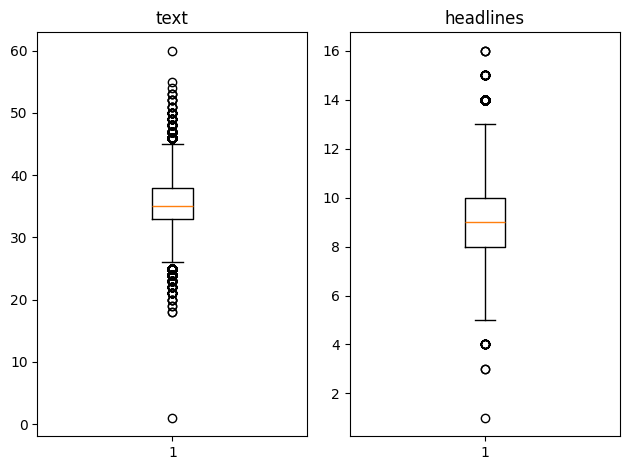

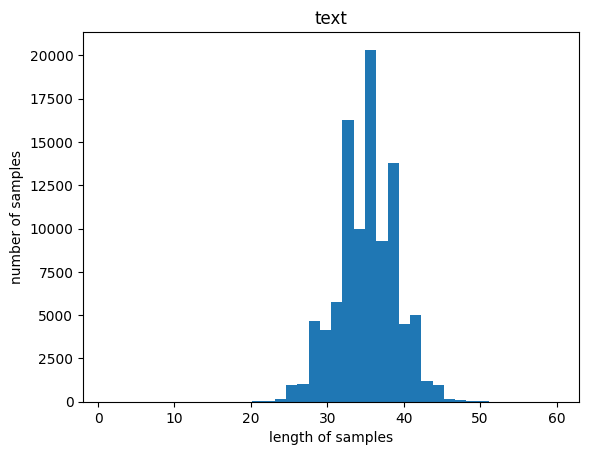

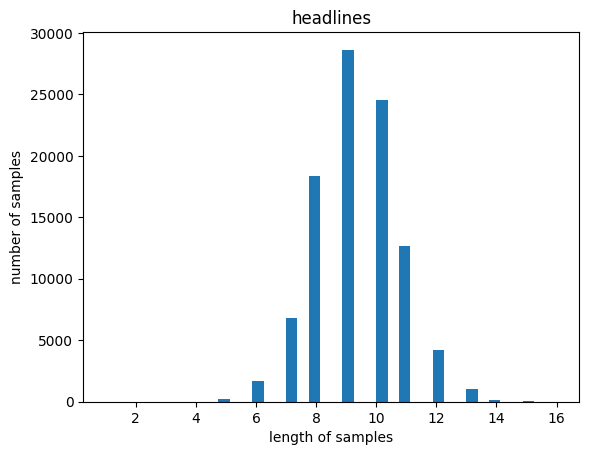

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687
전체 샘플수 : 80291
[ 4635 47361 73133 ... 68104 22964 58686]
테스트 데이터의 수 : 16058
훈련 데이터의 개수 : 64233
훈련 레이블의 개수 : 64233
테스트 데이터의 개수 : 16058
테스트 레이블의 개수 : 16058


In [22]:
(encoder_input_train, decoder_input_train, decoder_target_train,
               encoder_input_test, decoder_input_test, decoder_target_test) = create_train_test_sets(processor_re.data, text_max_len, headlines_max_len)

---
### 정수 인코딩

In [23]:
src_vocab = build_vocab(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [24]:
threshold = 7

# 전처리된 데이터 사용
text_data = processor_re.data['text'].tolist()
headlines_data = processor_re.data['headlines'].tolist()
# 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 76334
등장 빈도가 6번 이하인 희귀 단어의 수: 51776
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24558
단어 집합에서 희귀 단어의 비율: 67.82822857442294
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.0337692130558263


In [25]:
src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)

In [26]:
# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_test_seq[:3])

[[8, 56, 2, 48, 449, 446, 13, 2414, 206, 28, 1, 1, 2110, 2014, 1, 508, 4788, 190, 527, 2250, 2557, 771, 44, 1019, 4979, 48, 232, 2250, 44, 1841, 745, 5815, 59, 649], [1, 1, 89, 2587, 7852, 448, 261, 29, 163, 84, 121, 27, 2405, 710, 667, 3820, 3956, 3890, 242, 1, 100, 4, 624, 469, 2377, 800, 7852, 180, 635, 4751, 3563, 1383, 104, 1661], [8, 92, 73, 968, 531, 6486, 206, 19, 68, 1, 2847, 1245, 1451, 129, 10, 8, 2006, 2847, 684, 1, 1, 73, 829, 198, 70, 429, 968, 531, 1, 129, 7230, 2847]]
[[624, 426, 578, 54, 2, 1316, 1, 760, 4216, 297, 1456, 1, 3055, 2513, 557, 1, 3055, 205, 219, 120, 1, 1, 1346, 578, 420, 204, 109, 228, 406, 75, 6, 297, 1314, 266, 1839, 1, 150, 185], [278, 897, 2214, 961, 1, 156, 54, 1242, 4585, 1, 713, 115, 387, 162, 403, 961, 232, 156, 1710, 4331, 22, 1, 545, 2889, 1, 545, 1063, 919, 1165, 278, 115, 530, 4805, 143, 2463, 156, 1, 904, 405, 2], [86, 3738, 5009, 2, 1, 1602, 36, 5851, 1, 334, 660, 98, 1, 2, 1529, 26, 111, 517, 4864, 1274, 1380, 180, 3738, 5, 1047, 1, 6494, 

In [27]:
tar_vocab = build_vocab(decoder_input_train)

In [28]:
threshold = 6

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28416
등장 빈도가 5번 이하인 희귀 단어의 수: 18949
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9467
단어 집합에서 희귀 단어의 비율: 66.68426238738738
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.723684939947003


In [29]:
tar_vocab = build_limited_vocab(decoder_input_train + decoder_target_train, tar_vocab_size)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train_seq[:5])
print('target')
print('decoder ',decoder_target_train_seq[:5])

input
input  [[2, 31, 24, 324, 119, 10, 39, 1357, 1, 1662, 136], [2, 1063, 47, 1, 1, 1, 1], [2, 62, 72, 5, 1, 1836, 5, 66], [2, 389, 1, 1, 46, 19, 1, 85, 113], [2, 24, 47, 803, 411, 69, 1519, 144, 1, 1, 1586]]
target
decoder  [[31, 24, 324, 119, 10, 39, 1357, 1, 1662, 136, 3], [1063, 47, 1, 1, 1, 1, 3], [62, 72, 5, 1, 1836, 5, 66, 3], [389, 1, 1, 46, 19, 1, 85, 113, 3], [24, 47, 803, 411, 69, 1519, 144, 1, 1, 1586, 3]]


In [30]:
drop_train = [index for index, (seq_enc, seq_dec) in enumerate(zip(encoder_input_train, decoder_input_train))
              if len(seq_enc) == 0 or len(seq_dec) == 1]

drop_test = [index for index, (seq_enc, seq_dec) in enumerate(zip(encoder_input_test, decoder_input_test))
             if len(seq_enc) == 0 or len(seq_dec) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 64233
훈련 레이블의 개수 : 64233
테스트 데이터의 개수 : 16058
테스트 레이블의 개수 : 16058


In [31]:
# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=headlines_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=headlines_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=headlines_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=headlines_max_len)

---
### 모델 정의

In [35]:
# 인코더 모델 생성
encoder_re = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [36]:
# 디코더 모델 생성
decoder_re = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [40]:
# 모델 정의
Seq_mode_re = Seq2Seq(encoder_re, decoder_re, tar_vocab_size)
print(Seq_mode_re)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(2000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (softmax_layer): Linear(in_features=256, out_features=2000, bias=True)
)


In [41]:
# 모델 생성
SeqA_model_re = Seq2SeqWithAttention(encoder_re, decoder_re, tar_vocab_size, hidden_size)
print(SeqA_model_re)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(8000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(2000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (attention): Attention_dot(
    (attn): Linear(in_features=256, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (concat): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=2000, bias=True)
)


---
### 모델 훈련하기

In [42]:
# PyTorch DataLoader 설정
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
%%time
# 30분 이상 시간이 걸릴 수 있습니다. GPU 환경에서 학습하는 것을 권장합니다.
# 학습 실행
train_losses, val_losses = train_model(SeqA_model_re, train_loader, test_loader, criterion, epochs=epochs, patience=patience)

Epoch 1/50 | Train Loss: 5.0169 | Val Loss: 4.7458
Epoch 2/50 | Train Loss: 4.5425 | Val Loss: 4.2885
Epoch 3/50 | Train Loss: 4.1061 | Val Loss: 3.9176
Epoch 4/50 | Train Loss: 3.7762 | Val Loss: 3.6806
Epoch 5/50 | Train Loss: 3.5392 | Val Loss: 3.5194
Epoch 6/50 | Train Loss: 3.3585 | Val Loss: 3.4111
Epoch 7/50 | Train Loss: 3.2117 | Val Loss: 3.3348
Epoch 8/50 | Train Loss: 3.0857 | Val Loss: 3.2837
Epoch 9/50 | Train Loss: 2.9785 | Val Loss: 3.2392
Epoch 10/50 | Train Loss: 2.8833 | Val Loss: 3.2151
Epoch 11/50 | Train Loss: 2.7954 | Val Loss: 3.1955
Epoch 12/50 | Train Loss: 2.7163 | Val Loss: 3.1871
Epoch 13/50 | Train Loss: 2.6448 | Val Loss: 3.1826
Epoch 14/50 | Train Loss: 2.5785 | Val Loss: 3.1809
Epoch 15/50 | Train Loss: 2.5168 | Val Loss: 3.1855
Epoch 16/50 | Train Loss: 2.4582 | Val Loss: 3.2020
Epoch 17/50 | Train Loss: 2.4042 | Val Loss: 3.1940
Epoch 18/50 | Train Loss: 2.3531 | Val Loss: 3.2214
Epoch 19/50 | Train Loss: 2.3039 | Val Loss: 3.2301
Epoch 20/50 | Train L

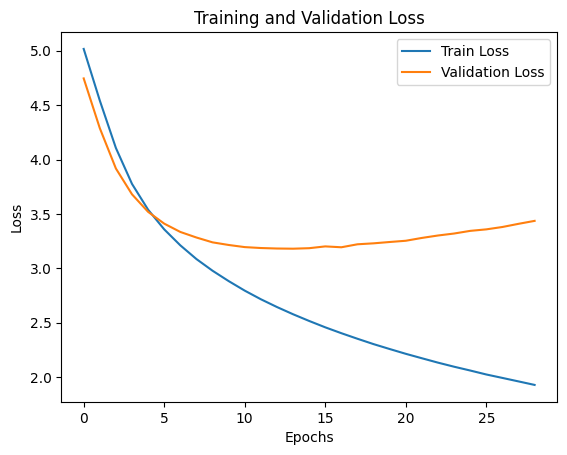

In [44]:
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

---
### 인퍼런스 모델 구현하기

In [45]:
src_index_to_word = {idx: word for word, idx in src_vocab.items()} # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_vocab # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()} # 요약 단어 집합에서 정수 -> 단어를 얻음

In [48]:
decoder_re.to(device)

# 이전 시점의 상태들을 저장하는 텐서
num_layers = 3  # 디코더 LSTM 레이어 개수 (설정에 맞춰 조정)
batch_size = 1

decoder_state_input_h = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_state_input_c = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_input = torch.zeros((batch_size, 1), dtype=torch.long, device=device)

dec_emb2 = decoder_re.embedding(decoder_input)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_re(decoder_input, decoder_state_input_h, decoder_state_input_c)


In [50]:
# 기존 Attention 클래스 사용
attention_layer = Attention_dot(hidden_size)

# 디코더 모델 생성
decoder_model = DecoderWithAttention(decoder_re, attention_layer, hidden_size, tar_vocab_size)

---
### 모델 테스트하기

In [52]:
%%time
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i], src_index_to_word))
    print("실제 요약 :", seq2headlines(decoder_input_test[i], tar_word_to_index, tar_index_to_word))
    input_seq = torch.tensor(encoder_input_test[i], dtype=torch.long, device=device).unsqueeze(0)
    print("예측 요약 :", decode_sequence(input_seq, encoder_re, decoder_re, tar_word_to_index, tar_index_to_word, text_max_len, headlines_max_len, device))
    print("\n")

원문 : <UNK> janata dal leader sharad yadav claimed rajasthan cm vasundhara raje become fat said actually feel insulted think even women insulted said election commission take <UNK> language set example future yadav later said joke meant derogatory
실제 요약 : feel <UNK> <UNK> on being called <UNK> by yadav
예측 요약 :  china china china takes leader sc top mp mp


원문 : year old <UNK> labourer died working one <UNK> fifa world cup qatar tournament organising body said investigation launched first reported death qatar world cup venue since british worker died falling nearly metres <UNK> international stadium january
실제 요약 : <UNK> worker dies at world cup stadium site in
예측 요약 :  house korea house killed it singh singh apple apple


원문 : jammu kashmir governor nn <UNK> friday made biometric attendance compulsory state government offices immediate effect move aimed ensuring <UNK> offices employees including <UNK> <UNK> <UNK> employees directed <UNK> salary would <UNK> <UNK>
실제 요약 : <UNK> <UNK> made

<timed exec>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_361064/3537739887.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)


예측 요약 :  china china house khan takes leader highest leader highest


원문 : encourage commuters use public transport curb pollution environment pollution authority recommended parking fee delhi ncr increased four times panel also recommended reducing delhi metro fares peak hours imposing fine road construction agencies violating dust pollution norms
실제 요약 : hike parking fee in delhi by four times <UNK>
예측 요약 :  house korea house state open open it highest singh


원문 : moody <UNK> yes bank ratings non investment grade changed <UNK> negative citing corporate governance concerns three yes bank directors including chairman ashok chawla resigned last two weeks <UNK> seen <UNK> rbi directive restrict term ceo rana kapoor raised concerns corporate governance moody said
실제 요약 : <UNK> <UNK> <UNK> bank after three director <UNK>
예측 요약 :  house son house son test new show highest crore


원문 : indian spinner ravichandran ashwin revealed virender sehwag hit harbhajan singh sixes game rohtak fever as

---
### 추출적 요약 해보기

In [53]:
Extractive(text)

sostoken india role in afghanistan would be detrimental pak pm
headlines:
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.
headlines:
['Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.']
headlines:
Morpheus and Neo are walking down a standard city street in what appears to be the Matrix.
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.
